In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

In [2]:
columns=['Customer Number', 'Offer Accepted', 'Reward', 'Mailer Type', 'Income Level','Bank Accounts Open', \
         'Overdraft Protection', 'Credit Rating','Credit Cards Held', 'Homes Owned', 'Household Size', \
         'Own Your Home', 'Average Balance', 'Q1 Balance', 'Q2 Balance',  'Q3 Balance', 'Q4 Balance']

In [3]:
df_init = pd.read_csv('./files/creditcardmarketing.csv', names=columns)
df_init.head(3)

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,Bank Accounts Open,Overdraft Protection,Credit Rating,Credit Cards Held,Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


In [4]:
# custom class for initial data cleaning
class CustomInitialDataCleaner:
    def __init__(self):
        pass
    
    def __remove_duplicates(self, X):
        return X[~X.duplicated()]
    
    def __standardize_feature_headers(self, X):
        X.columns = [col.lower().replace(' ', '_') for col in X.columns]
        return X
        
    def clean(self, X):
        X = self.__remove_duplicates(X)
        return self.__standardize_feature_headers(X)

In [5]:
cleaner = CustomInitialDataCleaner()
df = cleaner.clean(df_init)
df.set_index('customer_number', inplace=True)
df.head(3)

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


In [6]:
df_nans = df[df.isna().any(axis=1)]
yes = df_nans[df_nans['offer_accepted'] == 'Yes'].shape
no = df_nans[df_nans['offer_accepted'] == 'No'].shape

print(f'total rows with nan values: {df_nans.shape[0]}')
print(f'from nan rows, how many with offer accepted YES: ', yes[0])
print(f'from nan rows, how many with offer accepted NO: ', no[0])

total rows with nan values: 24
from nan rows, how many with offer accepted YES:  2
from nan rows, how many with offer accepted NO:  22


- since nan values in very few rows - drop the nans completely

In [7]:
df.dropna(inplace=True)
df.isna().sum()

offer_accepted          0
reward                  0
mailer_type             0
income_level            0
bank_accounts_open      0
overdraft_protection    0
credit_rating           0
credit_cards_held       0
homes_owned             0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
q4_balance              0
dtype: int64

## EDA

Check numerical features

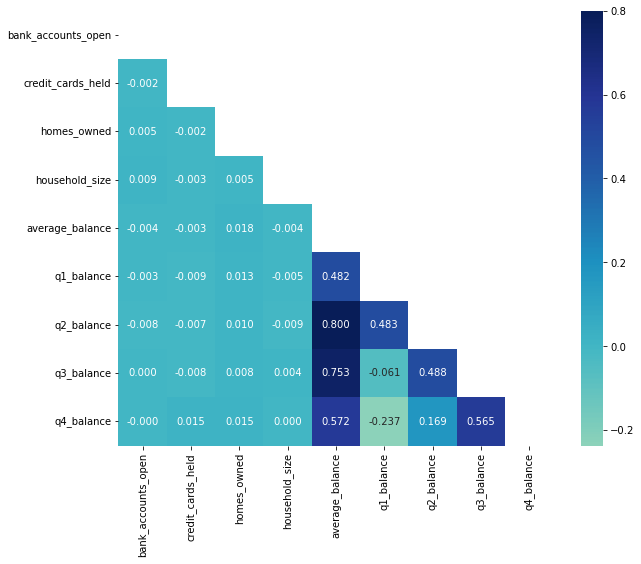

In [8]:
# correlation matrix:
num_corr = df.select_dtypes('number').corr()
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(num_corr, center=0, fmt=".3f", square=True, annot=True, mask=mask, cmap="YlGnBu")
plt.show()

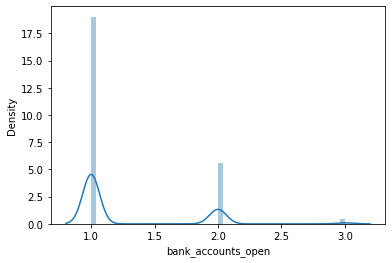

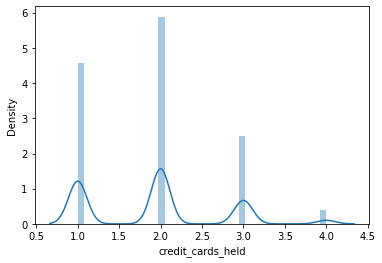

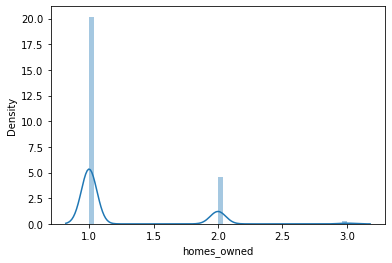

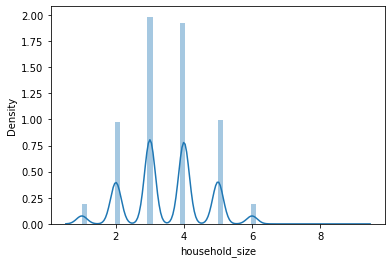

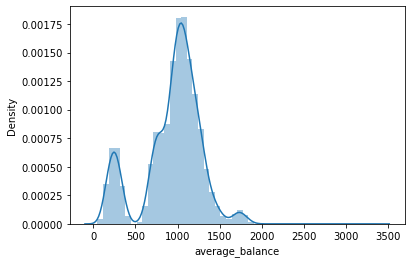

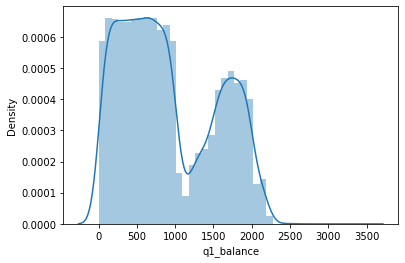

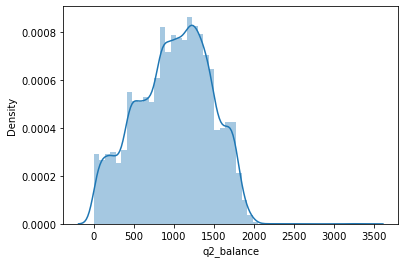

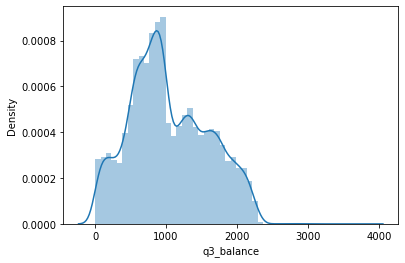

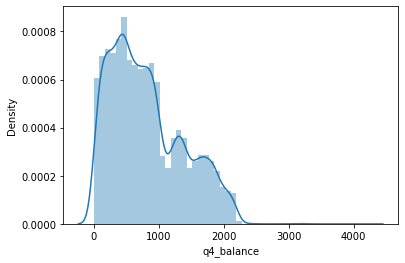

In [9]:
for col in df.select_dtypes('number'):
    sns.distplot(df[col])
    plt.show()

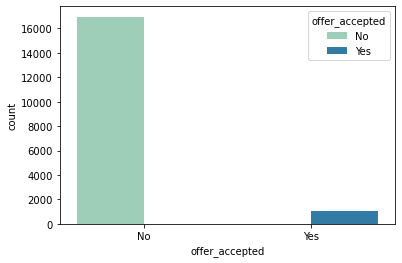

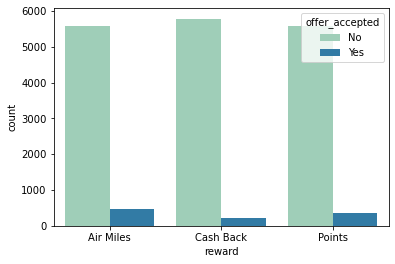

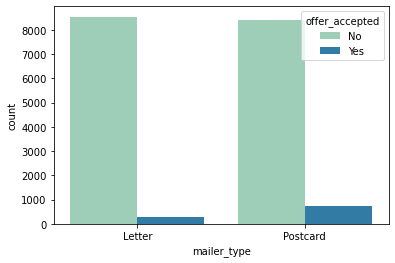

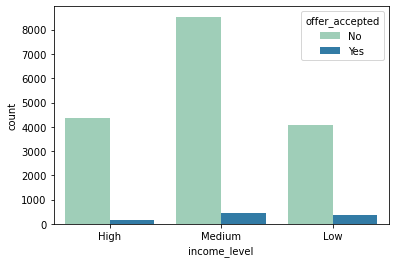

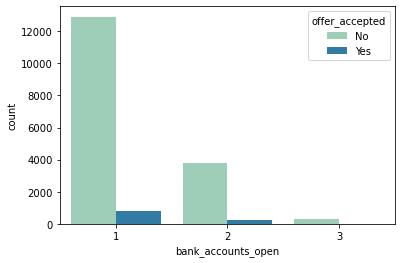

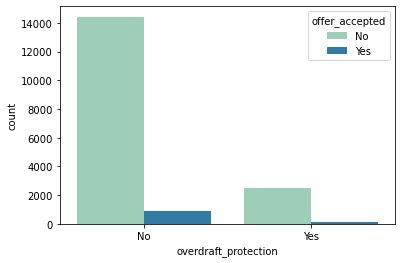

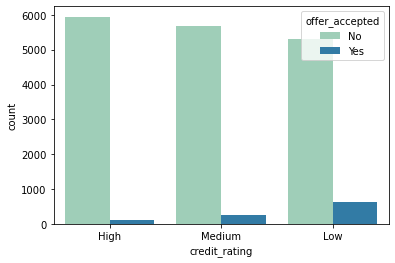

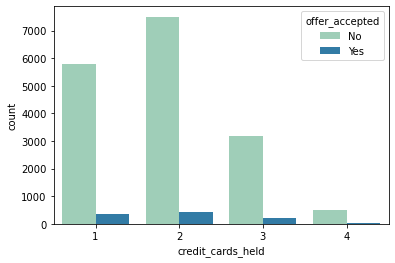

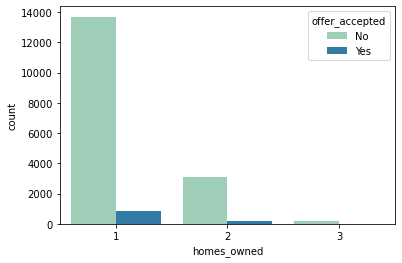

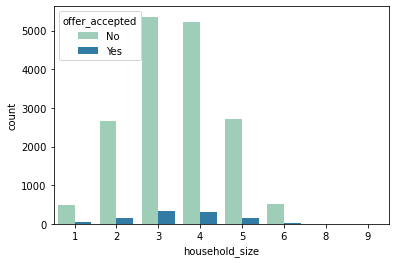

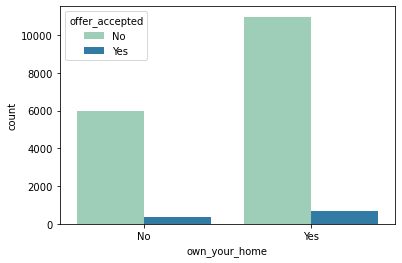

In [10]:
df_adjusted = df.loc[:, ~df.columns.isin(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance','average_balance'])]

for col in df_adjusted:
    sns.countplot(col, hue='offer_accepted', data=df, palette='YlGnBu')
    plt.show()

In [11]:
df.select_dtypes('object').apply(lambda col: col.unique())

offer_accepted                               [No, Yes]
reward                  [Air Miles, Cash Back, Points]
mailer_type                         [Letter, Postcard]
income_level                       [High, Medium, Low]
overdraft_protection                         [No, Yes]
credit_rating                      [High, Medium, Low]
own_your_home                                [No, Yes]
dtype: object

In [12]:
df['offer_accepted'].value_counts() / df.shape[0] * 100

No     94.320205
Yes     5.679795
Name: offer_accepted, dtype: float64

In [13]:
df['offer_accepted'].value_counts() 

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

#### Correlation Matrix

### Check for outliers

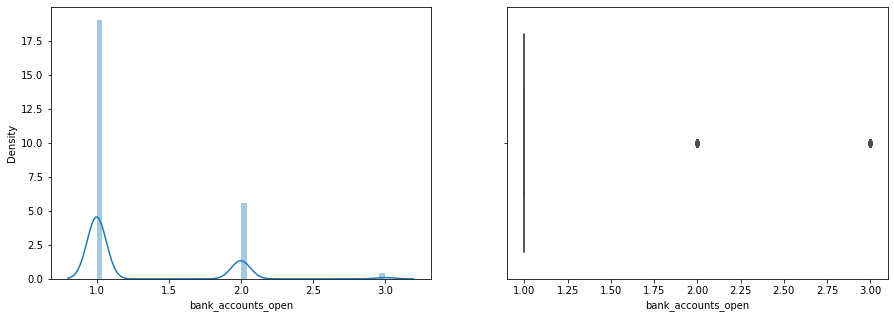

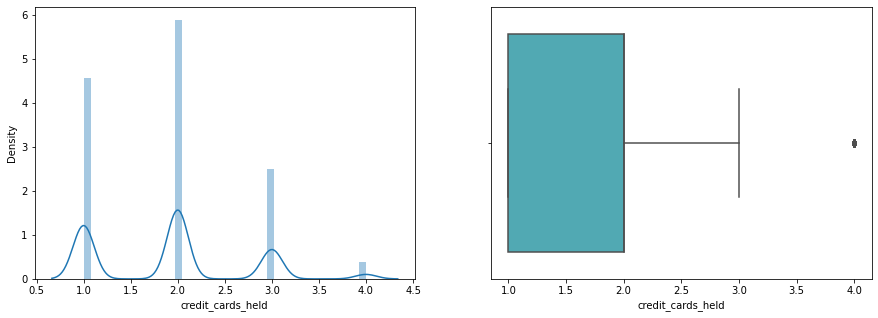

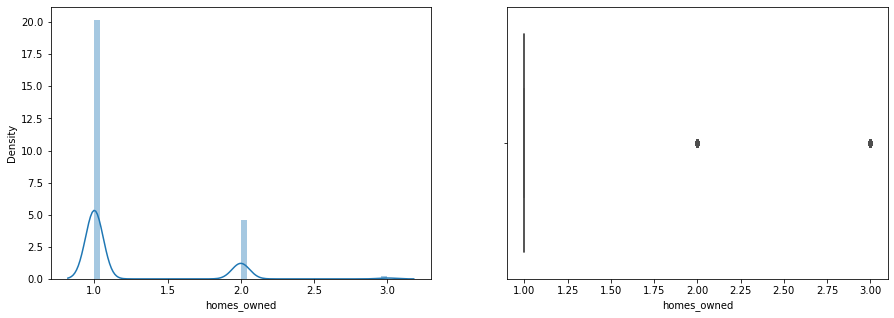

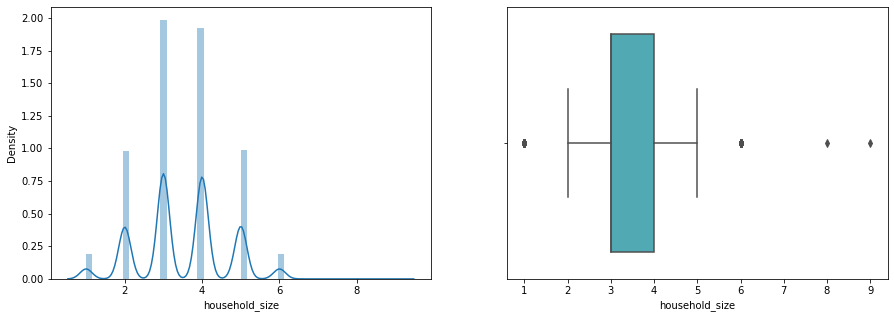

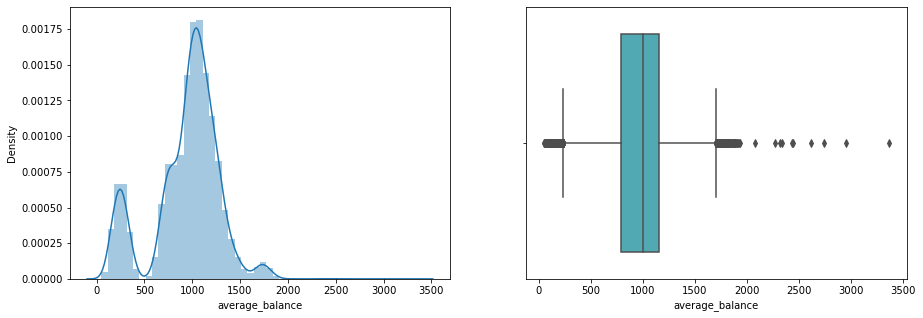

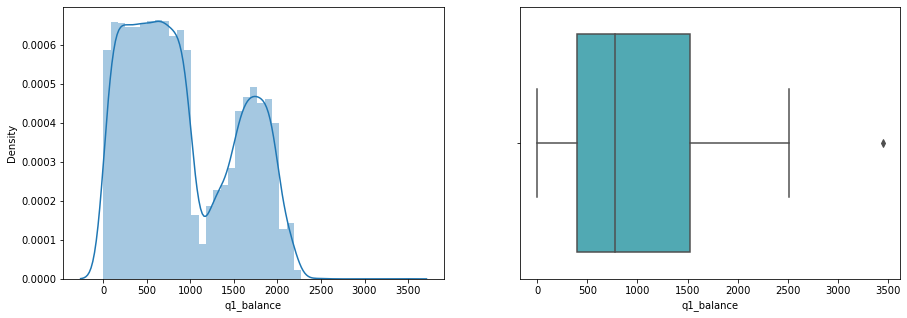

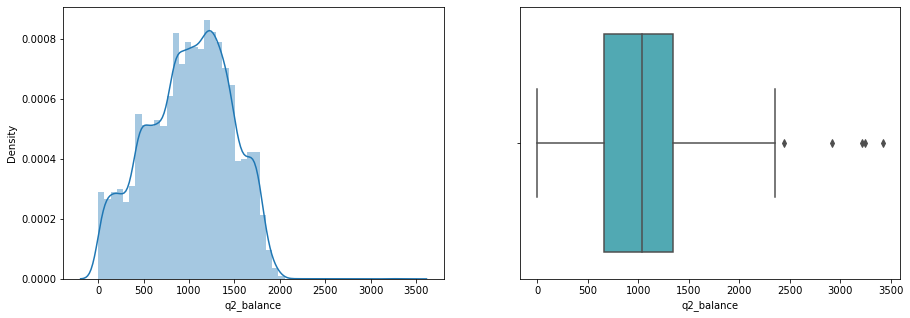

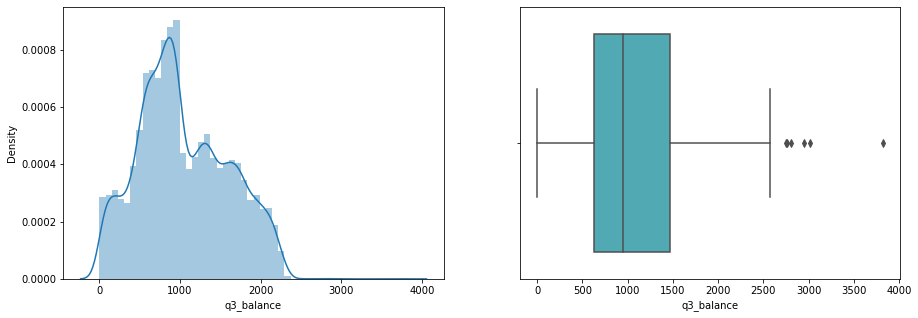

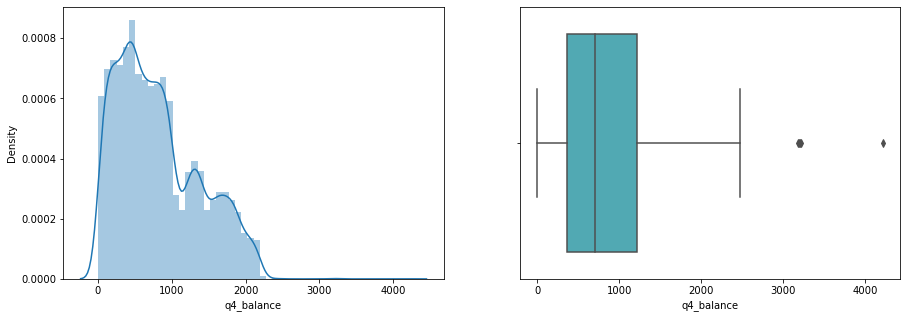

In [14]:
for col in df.select_dtypes('number'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.distplot(df[col], ax=ax[0])

    sns.boxplot(x=df[col], data=df, palette='YlGnBu', ax=ax[1])
    plt.show()
    

In [15]:
# TODO add outlier handling - prob in pipeline

## Data Preprocessing

In [16]:
# split data before any tranformations
X = df.drop('offer_accepted', axis=1, inplace=False)
y = df['offer_accepted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
numerical = df.select_dtypes('number')
categorical = df.select_dtypes('object').drop('offer_accepted', axis=1, inplace=False)
cat_ordinal_features = categorical[['income_level', 'credit_rating']].columns
cat_onehot_features = categorical.loc[:, ~categorical.columns.isin(cat_ordinal_features)].columns


# custom function to create pipelines with flexible scaler, sampler (to balance classes), and model
def make_custom_pipeline(scaler, sampler, model):
    custom_pipeline = Pipeline([
        ('scaling', ColumnTransformer([
            ('numerical', scaler, numerical.columns),
            ('cat_onehot', OneHotEncoder(sparse=False), cat_onehot_features),
            ('cat_ordinal', OrdinalEncoder(categories=[['Low', 'Medium', 'High'], \
                                                       ['Low', 'Medium', 'High']]), cat_ordinal_features),])),
        ('sampling', sampler),
        ('model', model)])
    
    return custom_pipeline

## Evaluate different models

In [18]:
# utility functions for model evaluation
from IPython.display import display_html
from itertools import chain, cycle

# function to display dataframes side by side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    

def handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, sampler, estimator, df_results):
    scores_train = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True)).T
    scores_test = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T
    
    display_classification_results(scores_train, scores_test, [[y_train_pred, y_train, 'CM for Traning Data'], \
                                   [y_test_pred, y_test, 'CM for Test Data']], sampler, estimator)
    
    add_scores_to_overall_results(df_results, scores_test, sampler, estimator)


# function to print relevant information from predictions
def display_classification_results(scores_train, scores_test, target_data, sampler, estimator):
    class_weight = estimator.get_params().get('class_weight')
    print('='*100)
    print(f'{get_class_name(sampler)} {get_class_name(estimator)} class weight: {class_weight}')

    display_side_by_side(scores_train, scores_test, titles=['Train','Test'])

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i in range(2):
        cm = confusion_matrix(target_data[i][1], target_data[i][0], labels=estimator.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
        disp.plot(colorbar=False, ax=ax[i])
        disp.ax_.set_title(target_data[i][2])
    plt.show()
    

def add_scores_to_overall_results(df_results, scores_test, sampler, estimator):
    df_results.loc[df_results.shape[0]] = [get_class_name(estimator), get_class_name(sampler),
                                           estimator.get_params().get('class_weight'), 
                                           scores_test.at["accuracy","f1-score"], scores_test.at["Yes","f1-score"],
                                          scores_test.at["Yes","precision"], scores_test.at["Yes","recall"],
                                          scores_test.at["No","f1-score"], scores_test.at["No","precision"],
                                          scores_test.at["No","recall"]]
    
def get_class_name(cl):
    return cl.__class__.__name__

### Apply Logistic Regression, KNN, and Decision Tree Classifier

In [19]:
model_comparisson = pd.DataFrame([], 
                                 columns=['model', 'sampler', 'class_weight', 'f1_score', 'yes_f1', \
                                          'yes_precision', 'yes_recall', 'no_f1', 'no_precision', 'no_recall'])

SMOTE LogisticRegression class weight: None


,precision,recall,f1-score,support
No,0.973777,0.689965,0.807664,13563.000000
Yes,0.118449,0.691554,0.202255,817.000000
accuracy,0.690056,0.690056,0.690056,0.690056
macro avg,0.546113,0.690760,0.504960,14380.000000
weighted avg,0.925182,0.690056,0.773268,14380.000000
,precision,recall,f1-score,support
No,0.973543,0.694281,0.810532,3392.000000
Yes,0.118946,0.686275,0.202752,204.000000
accuracy,0.693826,0.693826,0.693826,0.693826
macro avg,0.546245,0.690278,0.506642,3596.000000


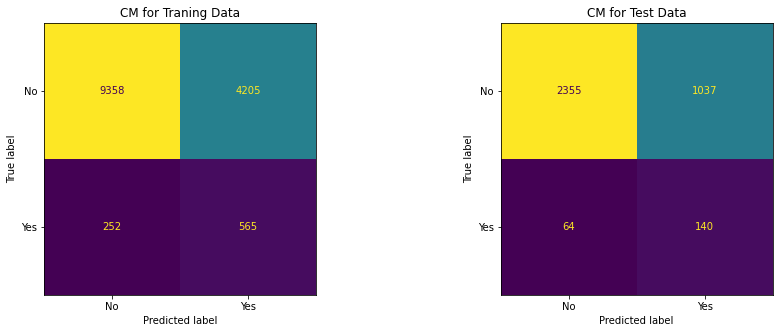

SMOTE LogisticRegression class weight: {'No': 1, 'Yes': 4}


,precision,recall,f1-score,support
No,0.990345,0.340338,0.506585,13563.000000
Yes,0.079432,0.944920,0.146545,817.000000
accuracy,0.374687,0.374687,0.374687,0.374687
macro avg,0.534889,0.642629,0.326565,14380.000000
weighted avg,0.938592,0.374687,0.486129,14380.000000
,precision,recall,f1-score,support
No,0.991095,0.328125,0.493023,3392.000000
Yes,0.078447,0.950980,0.144938,204.000000
accuracy,0.363459,0.363459,0.363459,0.363459
macro avg,0.534771,0.639553,0.318981,3596.000000


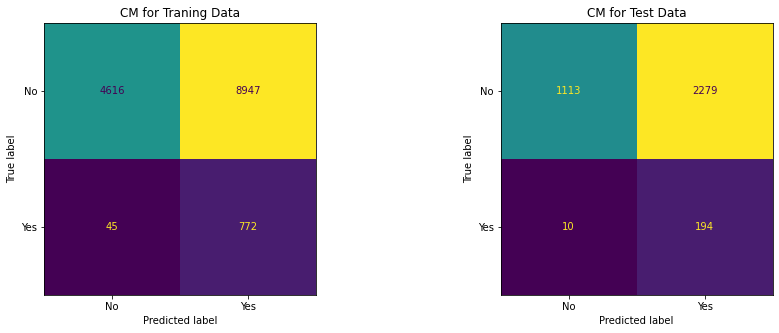

SMOTE KNeighborsClassifier class weight: None


,precision,recall,f1-score,support
No,1.000000,0.908722,0.952179,13563.000000
Yes,0.397567,1.000000,0.568942,817.000000
accuracy,0.913908,0.913908,0.913908,0.913908
macro avg,0.698783,0.954361,0.760560,14380.000000
weighted avg,0.965773,0.913908,0.930405,14380.000000
,precision,recall,f1-score,support
No,0.949492,0.825767,0.883318,3392.000000
Yes,0.085139,0.269608,0.129412,204.000000
accuracy,0.794216,0.794216,0.794216,0.794216
macro avg,0.517315,0.547687,0.506365,3596.000000


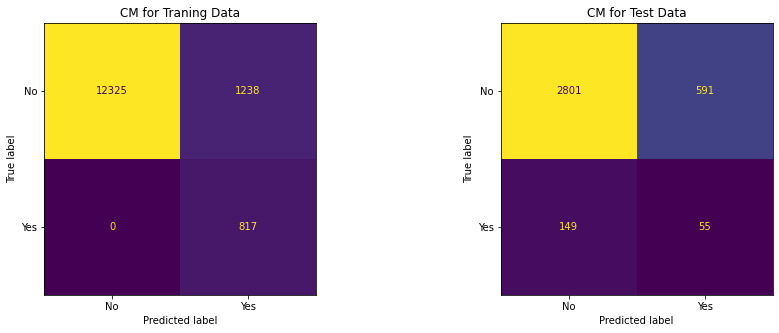

SMOTE DecisionTreeClassifier class weight: None


,precision,recall,f1-score,support
No,1.0,1.0,1.0,13563.0
Yes,1.0,1.0,1.0,817.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,14380.0
weighted avg,1.0,1.0,1.0,14380.0
,precision,recall,f1-score,support
No,0.946295,0.929835,0.937993,3392.000000
Yes,0.095057,0.122549,0.107066,204.000000
accuracy,0.884038,0.884038,0.884038,0.884038
macro avg,0.520676,0.526192,0.522529,3596.000000


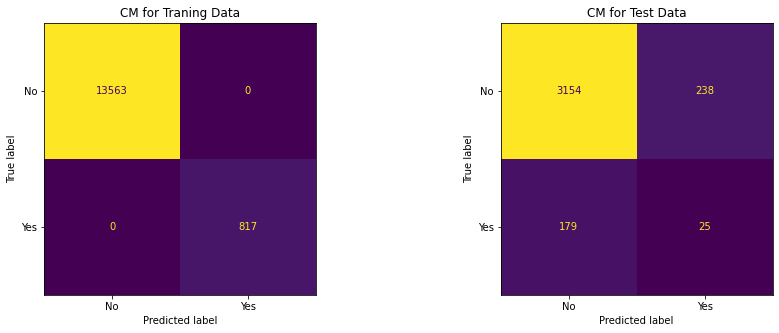

SMOTE DecisionTreeClassifier class weight: {'No': 1, 'Yes': 4}


,precision,recall,f1-score,support
No,1.0,1.0,1.0,13563.0
Yes,1.0,1.0,1.0,817.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,14380.0
weighted avg,1.0,1.0,1.0,14380.0
,precision,recall,f1-score,support
No,0.948146,0.927182,0.937547,3392.000000
Yes,0.114695,0.156863,0.132505,204.000000
accuracy,0.883482,0.883482,0.883482,0.883482
macro avg,0.531421,0.542022,0.535026,3596.000000


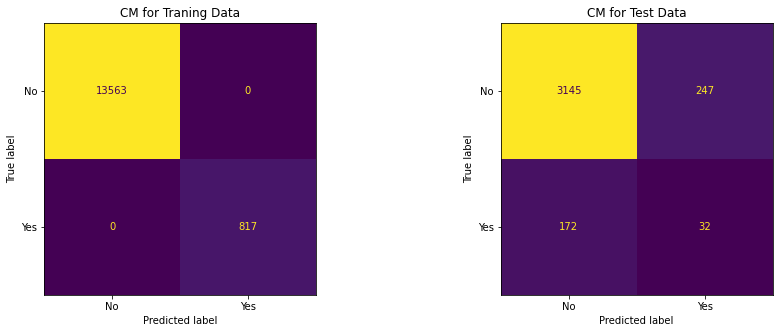

SMOTE RandomForestClassifier class weight: None


,precision,recall,f1-score,support
No,0.962430,0.857480,0.906929,13563.000000
Yes,0.158101,0.444308,0.233216,817.000000
accuracy,0.834006,0.834006,0.834006,0.834006
macro avg,0.560265,0.650894,0.570072,14380.000000
weighted avg,0.916732,0.834006,0.868652,14380.000000
,precision,recall,f1-score,support
No,0.960331,0.856427,0.905408,3392.000000
Yes,0.147110,0.411765,0.216774,204.000000
accuracy,0.831201,0.831201,0.831201,0.831201
macro avg,0.553720,0.634096,0.561091,3596.000000


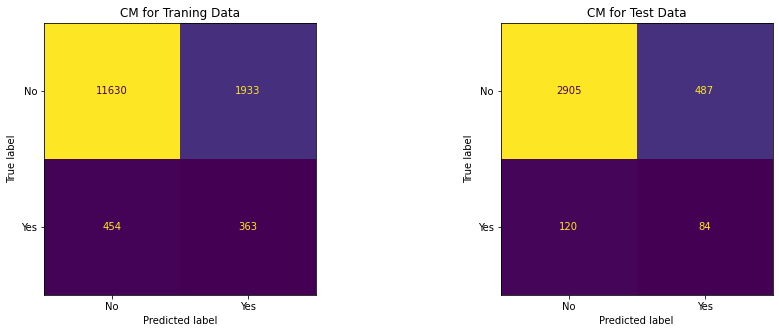

SMOTE RandomForestClassifier class weight: {'No': 1, 'Yes': 4}


,precision,recall,f1-score,support
No,0.988042,0.426454,0.595767,13563.000000
Yes,0.087614,0.914321,0.159906,817.000000
accuracy,0.454172,0.454172,0.454172,0.454172
macro avg,0.537828,0.670388,0.377836,14380.000000
weighted avg,0.936885,0.454172,0.571003,14380.000000
,precision,recall,f1-score,support
No,0.984061,0.418632,0.587384,3392.000000
Yes,0.084069,0.887255,0.153585,204.000000
accuracy,0.445217,0.445217,0.445217,0.445217
macro avg,0.534065,0.652943,0.370484,3596.000000


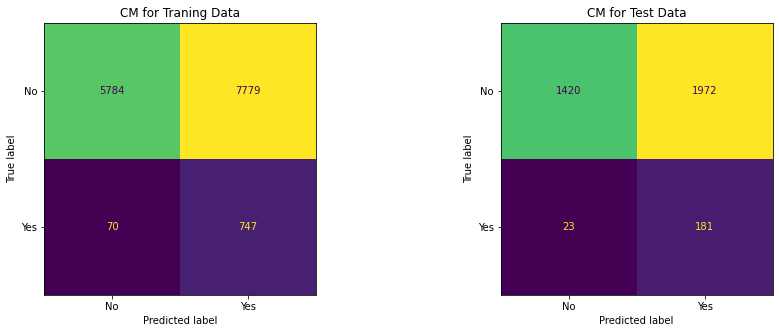

In [20]:
class_weight={'No': 1, 'Yes': 4}

classification_models = [
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         LogisticRegression(random_state=42, max_iter=10000)),
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         LogisticRegression(random_state=42, max_iter=10000, class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         KNeighborsClassifier(n_neighbors=3)),
    make_custom_pipeline(StandardScaler(), SMOTE(), DecisionTreeClassifier()),
    make_custom_pipeline(StandardScaler(), SMOTE(), DecisionTreeClassifier(class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), SMOTE(), RandomForestClassifier(max_depth=5, random_state=0)),
    make_custom_pipeline(StandardScaler(), SMOTE(), RandomForestClassifier(max_depth=5, random_state=0,\
                                                                           class_weight=class_weight))
]

# fit pipelines
for pipe in classification_models:
    pipe.fit(X_train, y_train)

# predict
for pipe in classification_models:
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, pipe[1], pipe[2], model_comparisson)

RandomUnderSampler LogisticRegression class weight: None


,precision,recall,f1-score,support
No,0.974935,0.665340,0.790920,13563.00000
Yes,0.114169,0.716034,0.196937,817.00000
accuracy,0.668220,0.668220,0.668220,0.66822
macro avg,0.544552,0.690687,0.493928,14380.00000
weighted avg,0.926031,0.668220,0.757173,14380.00000
,precision,recall,f1-score,support
No,0.975536,0.670106,0.794477,3392.00000
Yes,0.116114,0.720588,0.200000,204.00000
accuracy,0.672970,0.672970,0.672970,0.67297
macro avg,0.545825,0.695347,0.497239,3596.00000


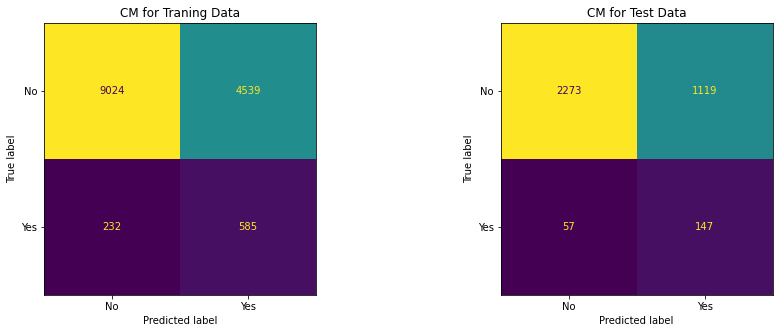

RandomUnderSampler LogisticRegression class weight: {'No': 1, 'Yes': 4}


,precision,recall,f1-score,support
No,0.994654,0.246922,0.395629,13563.000000
Yes,0.072551,0.977968,0.135080,817.000000
accuracy,0.288456,0.288456,0.288456,0.288456
macro avg,0.533602,0.612445,0.265355,14380.000000
weighted avg,0.942265,0.288456,0.380826,14380.000000
,precision,recall,f1-score,support
No,0.995157,0.242335,0.389758,3392.000000
Yes,0.072202,0.980392,0.134499,204.000000
accuracy,0.284205,0.284205,0.284205,0.284205
macro avg,0.533680,0.611364,0.262129,3596.000000


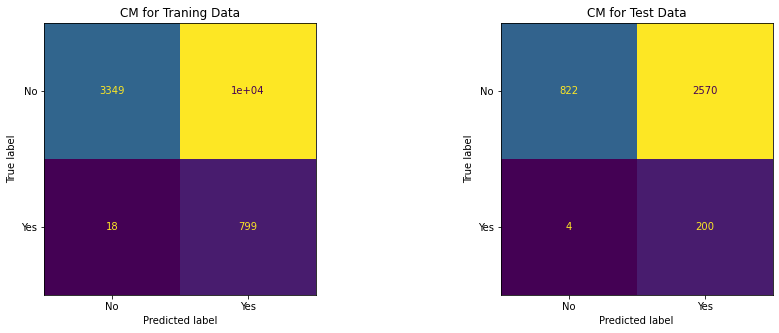

RandomUnderSampler KNeighborsClassifier class weight: None


,precision,recall,f1-score,support
No,0.979500,0.595370,0.740588,13563.000000
Yes,0.105606,0.793146,0.186394,817.000000
accuracy,0.606606,0.606606,0.606606,0.606606
macro avg,0.542553,0.694258,0.463491,14380.000000
weighted avg,0.929850,0.606606,0.709101,14380.000000
,precision,recall,f1-score,support
No,0.964827,0.582252,0.726236,3392.000000
Yes,0.085216,0.647059,0.150599,204.000000
accuracy,0.585929,0.585929,0.585929,0.585929
macro avg,0.525021,0.614656,0.438418,3596.000000


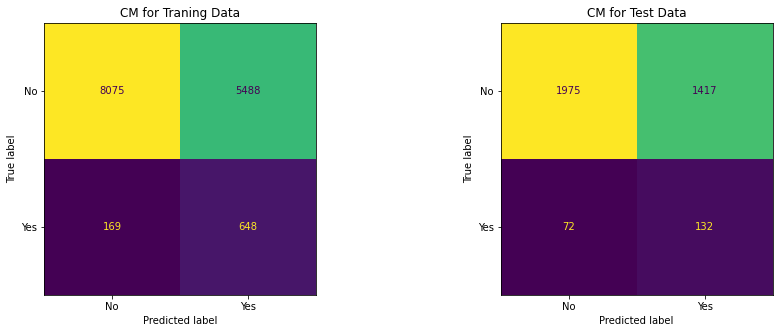

RandomUnderSampler DecisionTreeClassifier class weight: None


,precision,recall,f1-score,support
No,1.000000,0.634742,0.776565,13563.000000
Yes,0.141570,1.000000,0.248027,817.000000
accuracy,0.655494,0.655494,0.655494,0.655494
macro avg,0.570785,0.817371,0.512296,14380.000000
weighted avg,0.951228,0.655494,0.746536,14380.000000
,precision,recall,f1-score,support
No,0.952471,0.596698,0.733732,3392.000000
Yes,0.070020,0.504902,0.122985,204.000000
accuracy,0.591491,0.591491,0.591491,0.591491
macro avg,0.511245,0.550800,0.428359,3596.000000


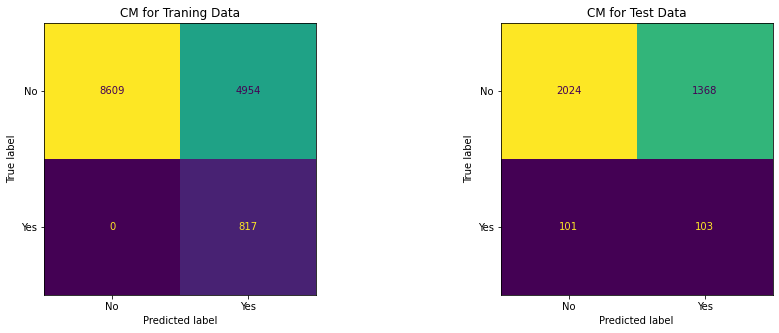

RandomUnderSampler DecisionTreeClassifier class weight: {'No': 1, 'Yes': 4}


,precision,recall,f1-score,support
No,1.000000,0.657008,0.793005,13563.000000
Yes,0.149387,1.000000,0.259943,817.000000
accuracy,0.676495,0.676495,0.676495,0.676495
macro avg,0.574694,0.828504,0.526474,14380.000000
weighted avg,0.951672,0.676495,0.762719,14380.000000
,precision,recall,f1-score,support
No,0.960035,0.651533,0.776256,3392.000000
Yes,0.086553,0.549020,0.149533,204.000000
accuracy,0.645717,0.645717,0.645717,0.645717
macro avg,0.523294,0.600276,0.462894,3596.000000


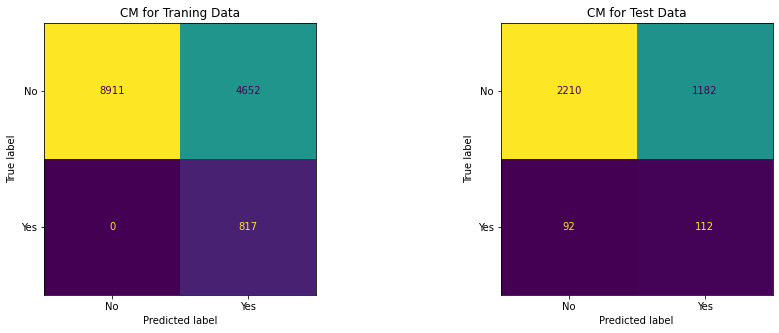

RandomUnderSampler RandomForestClassifier class weight: None


,precision,recall,f1-score,support
No,0.978472,0.683625,0.804896,13563.000000
Yes,0.125000,0.750306,0.214298,817.000000
accuracy,0.687413,0.687413,0.687413,0.687413
macro avg,0.551736,0.716965,0.509597,14380.000000
weighted avg,0.929982,0.687413,0.771341,14380.000000
,precision,recall,f1-score,support
No,0.971393,0.680719,0.800485,3392.000000
Yes,0.111567,0.666667,0.191145,204.000000
accuracy,0.679922,0.679922,0.679922,0.679922
macro avg,0.541480,0.673693,0.495815,3596.000000


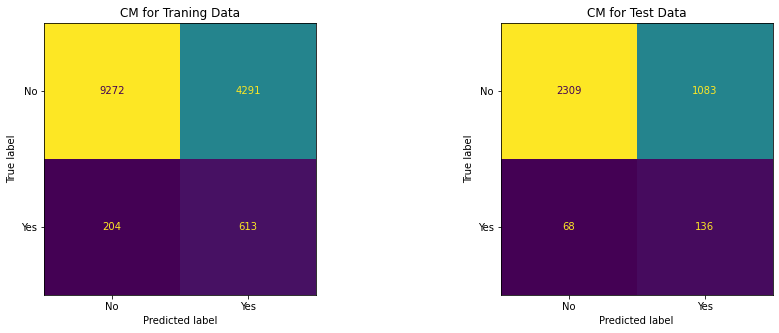

RandomUnderSampler RandomForestClassifier class weight: {'No': 1, 'Yes': 4}


,precision,recall,f1-score,support
No,0.999570,0.171422,0.292655,13563.000000
Yes,0.067695,0.998776,0.126797,817.000000
accuracy,0.218428,0.218428,0.218428,0.218428
macro avg,0.533633,0.585099,0.209726,14380.000000
weighted avg,0.946626,0.218428,0.283232,14380.000000
,precision,recall,f1-score,support
No,0.998224,0.165684,0.284197,3392.000000
Yes,0.066930,0.995098,0.125425,204.000000
accuracy,0.212736,0.212736,0.212736,0.212736
macro avg,0.532577,0.580391,0.204811,3596.000000


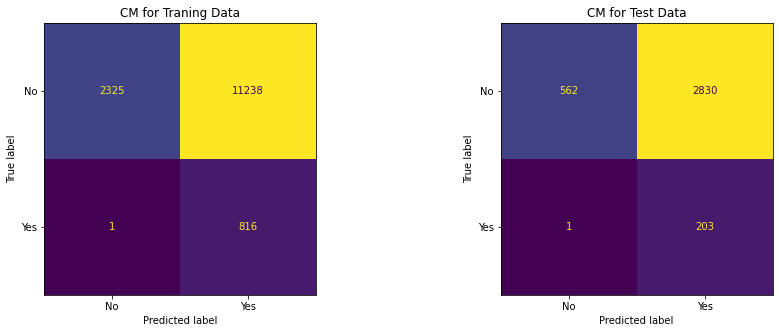

In [21]:
class_weight={'No': 1, 'Yes': 4}

classification_models_rus = [
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         LogisticRegression(random_state=42, max_iter=10000)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         LogisticRegression(random_state=42, max_iter=10000, class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         KNeighborsClassifier(n_neighbors=3)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), DecisionTreeClassifier()),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), DecisionTreeClassifier(class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), RandomForestClassifier(max_depth=5, \
                                                                                        random_state=0)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), RandomForestClassifier(max_depth=5,\
                                                                                        random_state=0,\
                                                                           class_weight=class_weight))
]

for pipe in classification_models_rus:
    pipe.fit(X_train, y_train)

# predict
for pipe in classification_models_rus:
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, pipe[1], pipe[2], model_comparisson)

In [22]:
model_comparisson

,model,sampler,class_weight,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
0,LogisticRegression,SMOTE,None,0.693826,0.202752,0.118946,0.686275,0.810532,0.973543,0.694281
1,LogisticRegression,SMOTE,"{'No': 1, 'Yes': 4}",0.363459,0.144938,0.078447,0.950980,0.493023,0.991095,0.328125
2,KNeighborsClassifier,SMOTE,None,0.794216,0.129412,0.085139,0.269608,0.883318,0.949492,0.825767
3,DecisionTreeClassifier,SMOTE,None,0.884038,0.107066,0.095057,0.122549,0.937993,0.946295,0.929835
4,DecisionTreeClassifier,SMOTE,"{'No': 1, 'Yes': 4}",0.883482,0.132505,0.114695,0.156863,0.937547,0.948146,0.927182
5,RandomForestClassifier,SMOTE,None,0.831201,0.216774,0.147110,0.411765,0.905408,0.960331,0.856427
6,RandomForestClassifier,SMOTE,"{'No': 1, 'Yes': 4}",0.445217,0.153585,0.084069,0.887255,0.587384,0.984061,0.418632
7,LogisticRegression,RandomUnderSampler,None,0.672970,0.200000,0.116114,0.720588,0.794477,0.975536,0.670106
8,LogisticRegression,RandomUnderSampler,"{'No': 1, 'Yes': 4}",0.284205,0.134499,0.072202,0.980392,0.389758,0.995157,0.242335
9,KNeighborsClassifier,RandomUnderSampler,None,0.585929,0.150599,0.085216,0.647059,0.726236,0.964827,0.582252
